In [1]:
import jsonlist

# Load in the massive dataset
data = jsonlist.load_file('cmv_20161111.jsonlist')

In [2]:
print(data[0].keys())
print()
print(data[0]['comments'][0].keys())

dict_keys(['contest_mode', 'suggested_sort', 'banned_by', 'media_embed', 'subreddit', 'selftext_html', 'selftext', 'likes', 'domain', 'user_reports', 'secure_media', 'saved', 'id', 'gilded', 'secure_media_embed', 'clicked', 'report_reasons', 'author', 'media', 'comments', 'name', 'score', 'approved_by', 'over_18', 'hidden', 'thumbnail', 'subreddit_id', 'edited', 'link_flair_css_class', 'author_flair_css_class', 'downs', 'mod_reports', 'archived', 'removal_reason', 'is_self', 'hide_score', 'spoiler', 'permalink', 'locked', 'stickied', 'created', 'url', 'author_flair_text', 'quarantine', 'title', 'created_utc', 'link_flair_text', 'distinguished', 'num_comments', 'visited', 'num_reports', 'ups'])

dict_keys(['subreddit_id', 'banned_by', 'removal_reason', 'link_id', 'likes', 'replies', 'user_reports', 'saved', 'id', 'gilded', 'archived', 'report_reasons', 'author', 'parent_id', 'score', 'approved_by', 'controversiality', 'body', 'edited', 'author_flair_css_class', 'downs', 'body_html', 'st

In [3]:
import networkx as nx

gAll = {}

# dump every single post into its own graph tree
for post_i in range(len(data)):
    g = nx.DiGraph()
    userOP = data[post_i]['author']
    userResponders = {}
    userToplevels = []
    commentInfo = {}
    for comment_i in range(len(data[post_i]['comments'])):
        author = '[deleted]'
        if 'author' in data[post_i]['comments'][comment_i]:
            author = data[post_i]['comments'][comment_i]['author']
        parentID = data[post_i]['comments'][comment_i]['parent_id']
        currentID = data[post_i]['comments'][comment_i]['name']
        g.add_edge(parentID, currentID)
        g.nodes[currentID]['comment_author'] = author
        commentInfo[currentID] = data[post_i]['comments'][comment_i]
        if author!='[deleted]' and author!='DeltaBot' and author!='AutoModerator':
            if author not in userResponders:
                userResponders[author] = []
            userResponders[author].append(currentID)
            if parentID==data[post_i]['name']:
                userToplevels.append(author)
    gAll[data[post_i]['name']] = {
        'post_graph': g,
        'user_op': userOP,
        'user_toplevels': list(set(userToplevels)),
        'user_responders': userResponders,
        'comment_data': commentInfo,
        'raw_data': data[post_i],
    }

t3_4ar1gm
LukeBabbitt
['Glory2Hypnotoad', 'clearedmycookies', 'ricraze', 'XiledLucifer', 'Morthra', 'ghebert001', 'TheMadSun', 'subtle_nirvana92', 'zensnapple', 'bluefire8q3', 'CarCrashRhetoric', 'kingbane', 'dangerzone133', 'LuckMaker', 'Omega037', 'rollingForInitiative', 'xthecharacter', 'potato59', 'Hq3473']
{'Omega037': ['t1_d12tvqg', 't1_d12wrgf'], 'Pinewood74': ['t1_d1387s1', 't1_d138dgf', 't1_d138j7s', 't1_d138a6v', 't1_d139jn5'], 'RiceOnTheRun': ['t1_d1380rh'], 'phoenixrawr': ['t1_d139mfp'], 'LukeBabbitt': ['t1_d12uf7e', 't1_d12ughe', 't1_d14hca1', 't1_d12ufma'], 'scottevil110': ['t1_d136bnc', 't1_d13abo0'], 'ccricers': ['t1_d13m92d', 't1_d13m7hp'], 'exosequitur': ['t1_d13c7x4', 't1_d13c455'], 'Mynotoar': ['t1_d13a8t1', 't1_d13ak8y'], 'xthecharacter': ['t1_d13eblk', 't1_d12za4e'], 'MrKittenz': ['t1_d13bqy9', 't1_d13fro8'], 'joeverdrive': ['t1_d13erzf', 't1_d13eh20', 't1_d13f2uy'], 'SirKaid': ['t1_d135y8q'], 'Belletrix': ['t1_d13wraw'], 'JangXa': ['t1_d133jpg'], 'KungFuSnorlax':

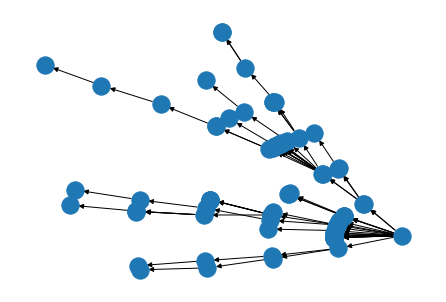

In [4]:
# test out the graph building
postID = list(gAll.keys())[3864]
postG = gAll[postID]['post_graph']
# print(postG.nodes.data())
nx.draw_kamada_kawai(
    postG, 
#     node_color=[
#         d['comment_author'] if 'comment_author' in d else gAll[postID]['user_op']
#         for (n,d) in postG.nodes.data()
#     ]
)
print(postID)
print(gAll[postID]['user_op'])
print(gAll[postID]['user_toplevels'])
print(gAll[postID]['user_responders'])

In [5]:
# count how many branches a user has touched
# path metric:
# count of how many unique paths are needed for all of the user's posts to be reached
def branch_count_paths(username, postID):
    # retrieve graph we are working with
    g = gAll[postID]['post_graph']
    # calculate path to each of the poster's comments
    commentPaths = {}
    for cID in gAll[postID]['user_responders'][username]:
        commentPaths[cID] = nx.shortest_path(g, postID, cID)
    # starting from longest path, remove all comments along that path (since theyre not unique)
    pathCount = 0
    while len(commentPaths) > 0:
#         print(commentPaths)
        deepestCID = sorted(
            [(k, len(commentPaths[k])) for k in commentPaths],
            key=(lambda x: x[1]),
        )
        deepestPath = commentPaths[deepestCID[-1][0]]
        for cID in deepestPath:
            commentPaths.pop(cID, None)
        pathCount += 1
    return pathCount

username = "ralpher313"
postID = "t3_5c8xdc"
print(branch_count_paths(username, postID))

3


In [6]:
# topic metric: 
# count of how many distinct top-level-comments the user has interacted with at any level
def branch_count_tlc(username, postID):
    # retrieve graph we are working with
    g = gAll[postID]['post_graph']
    # calculate TLC for each of the poster's comments
    commentTLC = {}
    for cID in gAll[postID]['user_responders'][username]:
        commentTLC[cID] = nx.shortest_path(g, postID, cID)
        # identify the top-level-comment this path interacts with
        commentTLC[cID] = commentTLC[cID][1]
    return len(set(commentTLC.values()))
    
username = "ralpher313"
postID = "t3_5c8xdc"
print(branch_count_tlc(username, postID))

3


In [7]:
# get branch count for responders
distribCount = {} # map from [number of branches]: [users who have had that number]
userCount = {}    # map from [usernames]: [branch distribution they've done]
for postID in gAll.keys():
    for u in gAll[postID]['user_toplevels']: # user_responders , user_toplevels
        if u!=gAll[postID]['user_op']:
            count = branch_count_tlc(u, postID)
            if count not in distribCount:
                distribCount[count] = []
            distribCount[count].append(u)
            if u not in userCount:
                userCount[u] = []
            userCount[u].append(count)

[(1, 44803), (2, 8254), (3, 2380), (4, 847), (5, 345), (6, 163), (7, 71), (8, 43), (9, 15), (10, 10), (11, 6), (12, 2), (13, 3), (16, 3), (22, 1)]


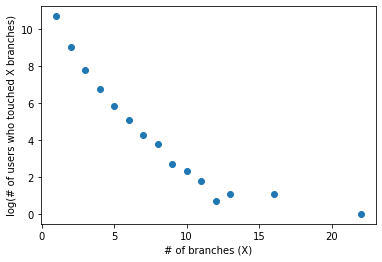

In [8]:
import math
import matplotlib.pyplot as plt

t = [(k, len(set(distribCount[k])), set(distribCount[k])) for k in distribCount.keys()]
t = [(a,b,c) for (a,b,c) in t if b!=0]
t = sorted(t, key=lambda x: x[0])
print([(a,b) for (a,b,c) in t])

plt.scatter(
    [b for (b, _, _) in t], 
    [math.log(fq) for (_, fq, _) in t], 
)
plt.xlabel('# of branches (X)')
plt.ylabel('log(# of users who touched X branches)')
plt.show()

(username, avg branches/post, max branches/post, #posts touched)
('hacksoncode', 1.2206339341205719, 7, 1609)
('cdb03b', 1.4393939393939394, 7, 1320)
('caw81', 1.0584362139917696, 5, 1215)
('Hq3473', 1.0765957446808512, 4, 1175)
('GnosticGnome', 1.0550541516245486, 3, 1108)
('DHCKris', 1.092896174863388, 4, 915)
('garnteller', 1.1940133037694014, 10, 902)
('forestfly1234', 1.3232662192393736, 11, 894)
('huadpe', 1.2933832709113608, 5, 801)
('anonoman925', 1.0190597204574332, 5, 787)


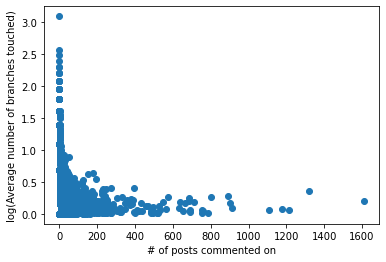

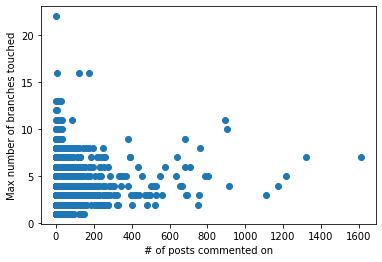

In [9]:
import math
import matplotlib.pyplot as plt

t = [(k, sum(userCount[k]), len(userCount[k]), max(userCount[k])) for k in userCount.keys()]
t = sorted(t, key=lambda x: x[2], reverse=True)
print('(username, avg branches/post, max branches/post, #posts touched)')
for i in ([(a,b/c,d,c) for (a,b,c,d) in t])[:10]:
    print(i)

plt.scatter(
    [pc for (_, _, pc, _) in t], 
    [math.log(sumB/numB) for (_, sumB, numB, _) in t], 
)
plt.xlabel('# of posts commented on')
plt.ylabel('log(Average number of branches touched)')
plt.show()

plt.scatter(
    [pc for (_, _, pc, _) in t], 
    [maxB for (_, _, _, maxB) in t], 
)
plt.xlabel('# of posts commented on')
plt.ylabel('Max number of branches touched')
plt.show()

In [10]:
import re

# get comment contents for responders
commentCount = []
for postID in gAll.keys():
    for u in gAll[postID]['user_toplevels']: # user_responders , user_toplevels
        if u!=gAll[postID]['user_op']:
            userNumBranchesPaths = branch_count_paths(u, postID)
            userNumBranchesTLC = branch_count_tlc(u, postID)
            userNumComments = len(gAll[postID]['user_responders'][u])
            for commentID in gAll[postID]['user_responders'][u]:
                contents = gAll[postID]['comment_data'][commentID]['body']
                hasQuestionMark = bool(re.search(r'\?', contents))
                parentID = gAll[postID]['comment_data'][commentID]['parent_id']
                respondingToUser = gAll[postID]['user_op']
                for parentU in gAll[postID]['user_responders']:
                    if parentID in gAll[postID]['user_responders'][parentU]:
                        respondingToUser = parentU
                commentCount.append((
                    postID,
                    commentID, 
                    u,
                    userNumComments, 
                    userNumBranchesPaths,
                    userNumBranchesTLC, 
                    contents,
                    int(hasQuestionMark),
                    int(respondingToUser==gAll[postID]['user_op']),
                    respondingToUser,
                ))
# tSelect = [e for e in commentCount if e[4]>1 and e[3]>e[4]][0]
# [e for e in commentCount if e[2]==tSelect[2] and e[0]==tSelect[0]]

In [11]:
tComments = {}
tQuestions = {}
tOPResponses = {}
tRespondees = {}
for c in commentCount:
    # post, uname, numComments, numBranchesPaths, numBranchesTLC
    p = (c[0], c[2], c[3], c[4], c[5]) 
    if p not in tComments:
        tComments[p] = []
    tComments[p].append(c[6]) # comment contents
    if p not in tQuestions:
        tQuestions[p] = []
    tQuestions[p].append(c[7]) # 1 if contains question mark, 0 if not
    if p not in tOPResponses:
        tOPResponses[p] = []
    tOPResponses[p].append(c[8]) # 1 if responding to OP, 0 if not
    if p not in tRespondees:
        tRespondees[p] = []
    tRespondees[p].append(c[9]) # who the commenter is responding to

for k in tComments:
    tComments[k] = [len(c) for c in tComments[k]]
tComments = [(k[2], k[3], k[4], tComments[k]) for k in tComments]
# one per responder per post
# each entry (#comments, #branchpaths, #branchtlc, [commentlengths])

tQuestions = [(k[2], k[3], k[4], tQuestions[k]) for k in tQuestions]
tQuestions = [(k[0], k[1], k[2], sum(k[3])/len(k[3])) for k in tQuestions]
# one per responder per post
# each entry (#comments, #branchpaths, #branchtlc, qlikelihood)

tOPResponses = [(k[2], k[3], k[4], tOPResponses[k]) for k in tOPResponses]
tOPResponses = [(k[0], k[1], k[2], sum(k[3])/len(k[3])) for k in tOPResponses]
# one per responder per post
# each entry (#comments, #branchpaths, #branchtlc, oplikelihood)

tRespondees = [(k[2], k[3], k[4], list(set(tRespondees[k]))) for k in tRespondees]
# one per responder per post
# each entry (#comments, #branchpaths, #branchtlc, [respondees, unique])

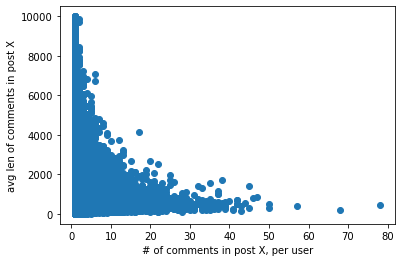

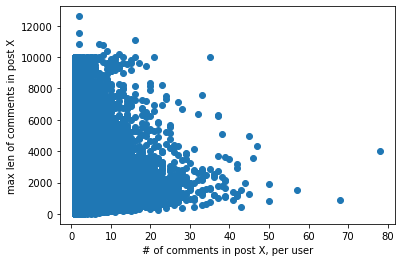

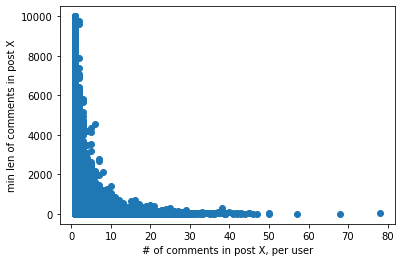

In [12]:
import math
import matplotlib.pyplot as plt

plt.scatter(
    [numc for (numc, numbp, numbt, lens) in tComments],
    [sum(lens)/len(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of comments in post X, per user')
plt.ylabel('avg len of comments in post X')
plt.show()

plt.scatter(
    [numc for (numc, numbp, numbt, lens) in tComments],
    [max(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of comments in post X, per user')
plt.ylabel('max len of comments in post X')
plt.show()

plt.scatter(
    [numc for (numc, numbp, numbt, lens) in tComments],
    [min(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of comments in post X, per user')
plt.ylabel('min len of comments in post X')
plt.show()

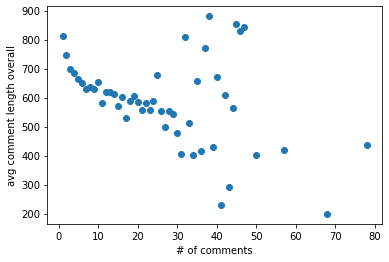

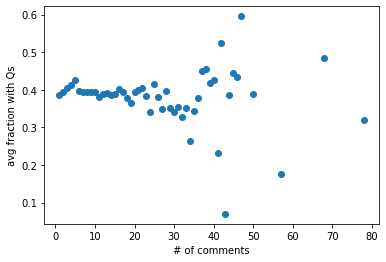

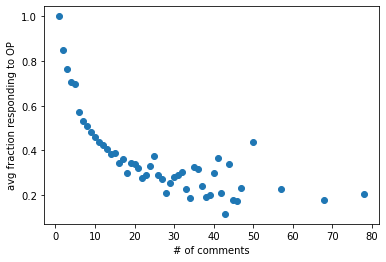

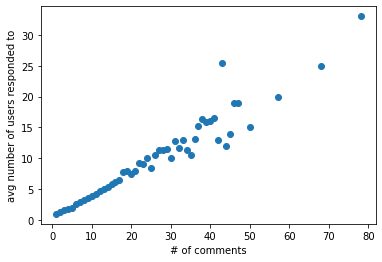

In [13]:
tLengthComments = []
for c in sorted(list(set([k[0] for k in tComments]))):
    totallen = sum([sum(k[3]) for k in tComments if k[0]==c])
    totalcount = sum([k[0] for k in tComments if k[0]==c])
    tLengthComments.append( (c, totallen/totalcount) )

plt.scatter(
    [numc for (numc, _) in tLengthComments],
    [avglen for (_, avglen) in tLengthComments]
)
plt.xlabel('# of comments')
plt.ylabel('avg comment length overall')
plt.show()

tQuestionsComments = []
for c in sorted(list(set([k[0] for k in tQuestions]))):
    totalqfs = sum([k[3]*k[0] for k in tQuestions if k[0]==c])
    totalcount = sum([k[0] for k in tQuestions if k[0]==c])
    tQuestionsComments.append( (c, totalqfs/totalcount) )

plt.scatter(
    [numc for (numc, _) in tQuestionsComments],
    [qf for (_, qf) in tQuestionsComments]
)
plt.xlabel('# of comments')
plt.ylabel('avg fraction with Qs')
plt.show()

tOPResponsesComments = []
for c in sorted(list(set([k[0] for k in tOPResponses]))):
    totalrfs = sum([k[3]*k[0] for k in tOPResponses if k[0]==c])
    totalcount = sum([k[0] for k in tOPResponses if k[0]==c])
    tOPResponsesComments.append( (c, totalrfs/totalcount) )

plt.scatter(
    [numc for (numc, _) in tOPResponsesComments],
    [rf for (_, rf) in tOPResponsesComments]
)
plt.xlabel('# of comments')
plt.ylabel('avg fraction responding to OP')
plt.show()

tRespondeeComments = []
for c in sorted(list(set([k[0] for k in tRespondees]))):
    totalrs = sum([len(k[3])*k[0] for k in tRespondees if k[0]==c])
    totalcount = sum([k[0] for k in tRespondees if k[0]==c])
    tRespondeeComments.append( (c, totalrs/totalcount) )

plt.scatter(
    [numc for (numc, _) in tRespondeeComments],
    [rs for (_, rs) in tRespondeeComments]
)
plt.xlabel('# of comments')
plt.ylabel('avg number of users responded to')
plt.show()

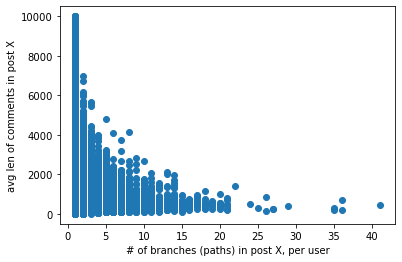

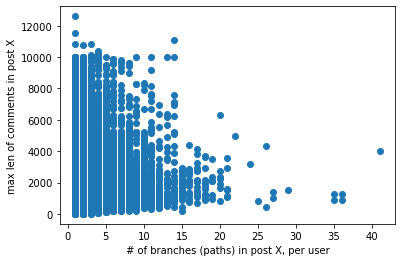

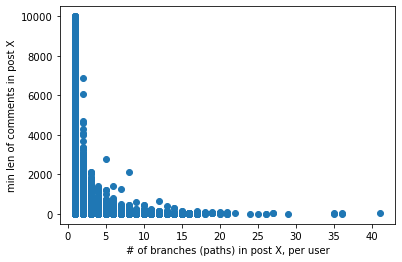

In [14]:
import math
import matplotlib.pyplot as plt

plt.scatter(
    [numbp for (numc, numbp, numbt, lens) in tComments],
    [sum(lens)/len(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of branches (paths) in post X, per user')
plt.ylabel('avg len of comments in post X')
plt.show()

plt.scatter(
    [numbp for (numc, numbp, numbt, lens) in tComments],
    [max(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of branches (paths) in post X, per user')
plt.ylabel('max len of comments in post X')
plt.show()

plt.scatter(
    [numbp for (numc, numbp, numbt, lens) in tComments],
    [min(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of branches (paths) in post X, per user')
plt.ylabel('min len of comments in post X')
plt.show()

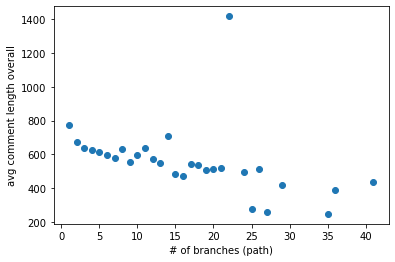

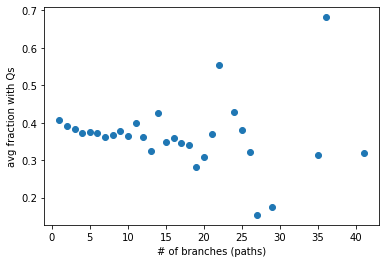

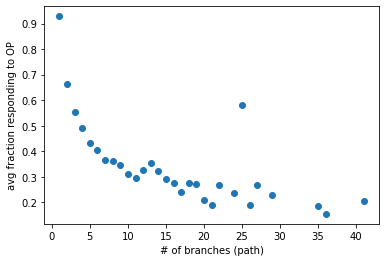

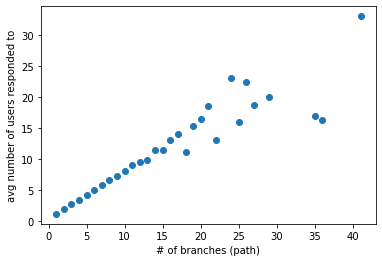

In [15]:
tLengthPathBranches = []
for bp in sorted(list(set([k[1] for k in tComments]))):
    totalls = sum([sum(k[3]) for k in tComments if k[1]==bp])
    totalcount = sum([k[0] for k in tComments if k[1]==bp])
    tLengthPathBranches.append( (bp, totalls/totalcount) )

plt.scatter(
    [numbp for (numbp, _) in tLengthPathBranches],
    [avglen for (_, avglen) in tLengthPathBranches]
)
plt.xlabel('# of branches (path)')
plt.ylabel('avg comment length overall')
plt.show()

tQuestionsPathBranches = []
for bp in sorted(list(set([k[1] for k in tQuestions]))):
    totalqfs = sum([k[3]*k[0] for k in tQuestions if k[1]==bp])
    totalcount = sum([k[0] for k in tQuestions if k[1]==bp])
    tQuestionsPathBranches.append( (bp, totalqfs/totalcount) )

plt.scatter(
    [numbp for (numbp, _) in tQuestionsPathBranches],
    [qf for (_, qf) in tQuestionsPathBranches]
)
plt.xlabel('# of branches (paths)')
plt.ylabel('avg fraction with Qs')
plt.show()

tOPResponsesPathBranches = []
for bp in sorted(list(set([k[1] for k in tOPResponses]))):
    totalrfs = sum([k[3]*k[0] for k in tOPResponses if k[1]==bp])
    totalcount = sum([k[0] for k in tOPResponses if k[1]==bp])
    tOPResponsesPathBranches.append( (bp, totalrfs/totalcount) )

plt.scatter(
    [numbp for (numbp, _) in tOPResponsesPathBranches],
    [rf for (_, rf) in tOPResponsesPathBranches]
)
plt.xlabel('# of branches (path)')
plt.ylabel('avg fraction responding to OP')
plt.show()

tRespondeePathBranches = []
for bp in sorted(list(set([k[1] for k in tRespondees]))):
    totalrs = sum([len(k[3])*k[0] for k in tRespondees if k[1]==bp])
    totalcount = sum([k[0] for k in tRespondees if k[1]==bp])
    tRespondeePathBranches.append( (bp, totalrs/totalcount) )

plt.scatter(
    [numc for (numc, _) in tRespondeePathBranches],
    [rs for (_, rs) in tRespondeePathBranches]
)
plt.xlabel('# of branches (path)')
plt.ylabel('avg number of users responded to')
plt.show()

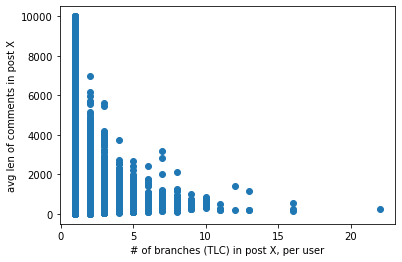

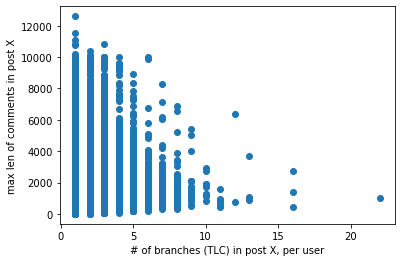

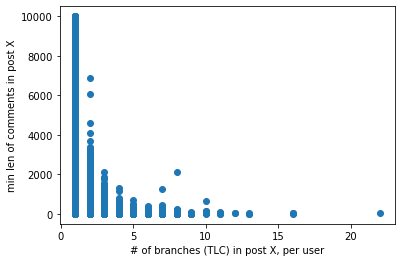

In [16]:
import math
import matplotlib.pyplot as plt

plt.scatter(
    [numbt for (numc, numbp, numbt, lens) in tComments],
    [sum(lens)/len(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of branches (TLC) in post X, per user')
plt.ylabel('avg len of comments in post X')
plt.show()

plt.scatter(
    [numbt for (numc, numbp, numbt, lens) in tComments],
    [max(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of branches (TLC) in post X, per user')
plt.ylabel('max len of comments in post X')
plt.show()

plt.scatter(
    [numbt for (numc, numbp, numbt, lens) in tComments],
    [min(lens) for (numc, numbp, numbt, lens) in tComments]
)
plt.xlabel('# of branches (TLC) in post X, per user')
plt.ylabel('min len of comments in post X')
plt.show()

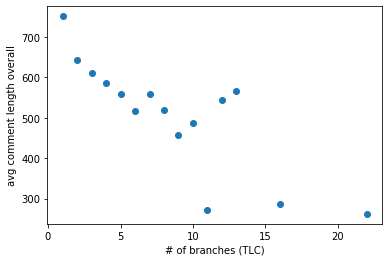

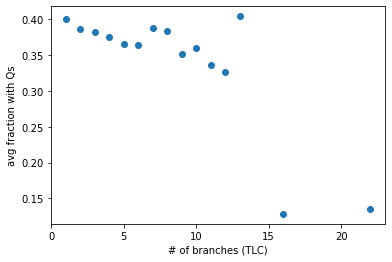

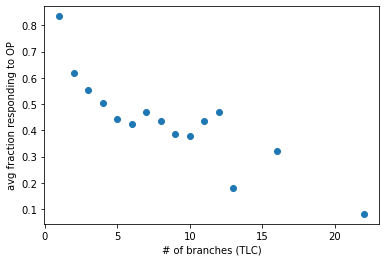

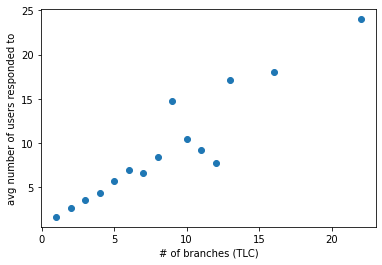

In [17]:
tLengthTLCBranches = []
for bt in sorted(list(set([k[2] for k in tComments]))):
    totalls = sum([sum(k[3]) for k in tComments if k[2]==bt])
    totalcount = sum([k[0] for k in tComments if k[2]==bt])
    tLengthTLCBranches.append( (bt, totalls/totalcount) )

plt.scatter(
    [numbt for (numbt, _) in tLengthTLCBranches],
    [avglen for (_, avglen) in tLengthTLCBranches]
)
plt.xlabel('# of branches (TLC)')
plt.ylabel('avg comment length overall')
plt.show()

tQuestionsTLCBranches = []
for bt in sorted(list(set([k[2] for k in tQuestions]))):
    totalqfs = sum([k[3]*k[0] for k in tQuestions if k[2]==bt])
    totalcount = sum([k[0] for k in tQuestions if k[2]==bt])
    tQuestionsTLCBranches.append( (bt, totalqfs/totalcount) )

plt.scatter(
    [numbt for (numbt, _) in tQuestionsTLCBranches],
    [qf for (_, qf) in tQuestionsTLCBranches]
)
plt.xlabel('# of branches (TLC)')
plt.ylabel('avg fraction with Qs')
plt.show()

tOPResponsesTLCBranches = []
for bt in sorted(list(set([k[2] for k in tOPResponses]))):
    totalrfs = sum([k[3]*k[0] for k in tOPResponses if k[2]==bt])
    totalcount = sum([k[0] for k in tOPResponses if k[2]==bt])
    tOPResponsesTLCBranches.append( (bt, totalrfs/totalcount) )

plt.scatter(
    [numbt for (numbt, _) in tOPResponsesTLCBranches],
    [rf for (_, rf) in tOPResponsesTLCBranches]
)
plt.xlabel('# of branches (TLC)')
plt.ylabel('avg fraction responding to OP')
plt.show()

tRespondeeTLCBranches = []
for bt in sorted(list(set([k[2] for k in tRespondees]))):
    totalrs = sum([len(k[3])*k[0] for k in tRespondees if k[2]==bt])
    totalcount = sum([k[0] for k in tRespondees if k[2]==bt])
    tRespondeeTLCBranches.append( (bt, totalrs/totalcount) )

plt.scatter(
    [numc for (numc, _) in tRespondeeTLCBranches],
    [rs for (_, rs) in tRespondeeTLCBranches]
)
plt.xlabel('# of branches (TLC)')
plt.ylabel('avg number of users responded to')
plt.show()

In [18]:
# import re

# # OP's notable contents

# print('-> title')
# print(data[0]['title'])
# print()

# print('-> author')
# print(data[0]['author'])
# print()

# print('-> selftext')
# # Remove the auto-added CMV post footer
# print(re.split(r'\n\_\_\_\_\_', data[0]['selftext'])[0])
# print()

# print('-> created, link_flair_text, permalink')
# print(data[0]['created'], data[0]['link_flair_text'], data[0]['permalink'])
# print()

# print('-> score, ups, downs')
# print(data[0]['score'], data[0]['ups'], data[0]['downs'])
# print()